<a href="https://colab.research.google.com/github/sumanyurosha/hackathons/blob/master/AnalyticsVidya/JanataHackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
We are given a dataset of vehicles where we have to classify them as **Emergency** (like Ambulance, Fire-brigade, Police car) and **Non-emergency** (like car, bus, truck) vehicles. 

# Solution Proposed
I will use a pre-trained model like VGG or Resnet as a feature extractor and then re-train the classifier layer of it for the above task.

# Steps for Vehicle Classification

1.   Downloading/unzip the dataset 
2.   Making a custom Data Loader
3.   Visualizing the Dataset
4.   Designing the model architecture
5.   Traing the model
6.   Model evaluation







In [1]:
# downloading the weights and config file for YOLOv3
!wget -c https://pjreddie.com/media/files/yolov3.weights
!wget -c https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg

--2020-06-21 02:32:07--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 248007048 (237M), 62999227 (60M) remaining [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[++++++++++++++=====>] 236.52M  1.85MB/s    in 31s     

2020-06-21 02:32:39 (1.91 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2020-06-21 02:32:41--  https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[====

In [0]:
import pandas as pd
import torch
import os
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io
import numpy as np


class VehicleDataset(Dataset):

    def __init__(self, csv_file, image_dir, transform, train=True):

        self.vehicle_mapping = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.vehicle_mapping)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = os.path.join(self.image_dir, self.vehicle_mapping.iloc[idx, 0])
        image = cv2.imread(image_path)
        image = self.transform(image)
        if (self.train):
            label = torch.tensor(int(self.vehicle_mapping.iloc[idx, 1]))
            return (image, label)
        else:
            return image#, self.vehicle_mapping.iloc[idx, 0]

class CropVehicle(object):

    def __call__(self, image):
        original = image.copy()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        canny = cv2.Canny(blurred, 120, 255, 1)
        kernel = np.ones((5,5),np.uint8)
        dilate = cv2.dilate(canny, kernel, iterations=1)

        # Find contours
        cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]

        # Iterate thorugh contours and find the largest rectangle
        area = 0
        for c in cnts:
            _x,_y,_w,_h = cv2.boundingRect(c)
            _area = (_w)*(_h)
            if _area > area:
                area = _area
                x,y,w,h = _x,_y,_w,_h

        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
        ROI = original[y:y+h, x:x+w]
        image = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)

        return image

In [0]:
# store classes name
yolo_classes = [
'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# generate different colors for different classes 
yolo_COLORS = np.random.uniform(0, 255, size=(len(yolo_classes), 3))

# function to get the output layer names 
# in the architecture
def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(yolo_classes[class_id])

    color = yolo_COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

def round_off(x):

    if x < 0:
        return 0
    elif x > 224:
        return 224
    else:
        return round(x)

In [0]:
class YoloCropVehicle(object):

    def __call__(self, image):
        # read input image
        # image = cv2.imread(image_dir + '/1000.jpg')
        original = image.copy()
        ROI = image.copy()

        Width = image.shape[1]
        Height = image.shape[0]

        # print('height:{} , width:{}'.format(Height, Width))
        scale = 0.00392

        # read pre-trained model and config file
        net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

        # create input blob 
        blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

        # set input blob for the network
        net.setInput(blob)

        # run inference through the network
        # and gather predictions from output layers
        outs = net.forward(get_output_layers(net))

        # initialization
        class_ids = []
        confidences = []
        boxes = []
        conf_threshold = 0.5
        nms_threshold = 0.4

        # for each detetion from each output layer 
        # get the confidence, class id, bounding box params
        # and ignore weak detections (confidence < 0.5)
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0] * Width)
                    center_y = int(detection[1] * Height)
                    w = int(detection[2] * Width)
                    h = int(detection[3] * Height)
                    x = center_x - w / 2
                    y = center_y - h / 2
                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])


        # apply non-max suppression
        indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

        # go through the detections remaining
        # after nms and choose the one with Class Rule, Confidence Rule and Area Rule

        idx = -1
        max_area = 0.
        max_confidence = 0.
        conf_idx = -1
        expected_classes = ['car', 'bus', 'truck']

        for i in indices:
            i = i[0]
            box = boxes[i]
            _x = box[0]
            _y = box[1]
            _w = box[2]
            _h = box[3]
            area = _w * _h

            # Area rule
            if max_area < area :
                max_area = area
                x, y, w, h = _x, _y, _w, _h
                idx = i

            # Class Rule and Confidence Rule
            if yolo_classes[class_ids[i]] in expected_classes and max_confidence < confidences[i]:
                max_confidence = confidences[i]
                conf_idx = i
                c_x, c_y, c_w, c_h = _x, _y, _w, _h
                max_conf_area = area
            
            # print('area : {} for class: {} and confidence: {}'.format(area, yolo_classes[class_ids[i]], confidences[i]))

        # print('largest area : {}'.format(max_area))

        # if conf_idx != -1:
            # print('{} class had the most confidence: {}'.format(
            #     yolo_classes[class_ids[conf_idx]], confidences[conf_idx]))
            
            # draw_bounding_box(image, class_ids[conf_idx], confidences[conf_idx],
            #                 round_off(c_x), round_off(c_y), round_off(c_x + c_w),
            #                 round_off(c_y + c_h))

        crop = False
        if conf_idx != -1 and idx != -1 :
            if max_conf_area / max_area > 0.6 :
                crop = True
            
        if crop :
            image = image[round_off(c_y):round_off(c_y + c_h), round_off(c_x):round_off(c_x + c_w)]

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        return image


In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# number of samples per batch
batch_size = 20
# validation set size
valid_size = 0.2
# test set size
test_size = 0.2

image_dir = "/content/drive/My Drive/Resources/Dataset/janata-hackathon/images"
train_csv_file = "/content/drive/My Drive/Resources/Dataset/janata-hackathon/train.csv"
test_csv_file = "/content/drive/My Drive/Resources/Dataset/janata-hackathon/test_vc2kHdQ.csv"

train_transform = transforms.Compose([#transforms.ToPILImage(),
                                    #  transforms.RandomHorizontalFlip(p=0.5),
                                    #  transforms.RandomRotation(degrees=30),
                                    #  CropVehicle(),
                                      YoloCropVehicle(),
                                      transforms.ToPILImage(),
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])]
                                    )

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

train_dataset = VehicleDataset(train_csv_file, image_dir, train_transform, 
                               train=True)
test_dataset = VehicleDataset(test_csv_file, image_dir, train_transform, 
                              train=False)

# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

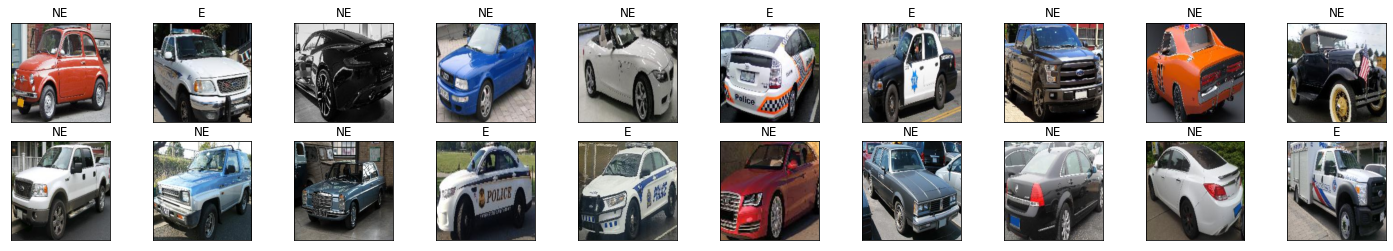

In [7]:
classes = ['NE', 'E']

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(classes[labels[idx]])
    ax.set_title(classes[labels[idx]])

In [0]:
# store classes name
yolo_classes = [
'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# generate different colors for different classes 
yolo_COLORS = np.random.uniform(0, 255, size=(len(yolo_classes), 3))

# function to get the output layer names 
# in the architecture
def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(yolo_classes[class_id])

    color = yolo_COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

def round_off(x):

    if x < 0:
        return 0
    elif x > 224:
        return 224
    else:
        return round(x)


def crop_out(name):
    # read input image
    image = cv2.imread(image_dir + name)
    # image = torch.tensor(image).cuda()
    print('image {}'.format(type(image)))

    Width = image.shape[1]
    Height = image.shape[0]

    # print('height:{} , width:{}'.format(Height, Width))
    scale = 0.00392

    # read pre-trained model and config file
    net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
    # net = torch.tensor(net).cuda()
    print('net {}'.format(type(net)))

    # create input blob 
    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)
    # blob = torch.tensor(blob).cuda()
    print('blob {}'.format(type(blob)))

    # set input blob for the network
    net.setInput(blob)

    # run inference through the network
    # and gather predictions from output layers
    outs = net.forward(get_output_layers(net))

    # initialization
    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4

    # for each detetion from each output layer 
    # get the confidence, class id, bounding box params
    # and ignore weak detections (confidence < 0.5)
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])


    # apply non-max suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    indices = torch.tensor(indices).cuda()

    # go through the detections remaining
    # after nms and choose the one with max area
    idx = -1
    max_area = 0.
    max_confidence = 0.
    conf_idx = -1
    expected_classes = ['car', 'bus', 'truck']

    for i in indices:
        i = i[0]
        box = boxes[i]
        _x = box[0]
        _y = box[1]
        _w = box[2]
        _h = box[3]
        area = _w * _h

        # Area rule
        if max_area < area :
            max_area = area
            x, y, w, h = _x, _y, _w, _h
            idx = i

        # Class Rule and Confidence Rule
        if yolo_classes[class_ids[i]] in expected_classes and max_confidence < confidences[i]:
            max_confidence = confidences[i]
            conf_idx = i
            c_x, c_y, c_w, c_h = _x, _y, _w, _h
            max_conf_area = area
        
        print('area : {} for class: {} and confidence: {}'.format(area, yolo_classes[class_ids[i]], confidences[i]))

    print('largest area : {}'.format(max_area))
    if conf_idx != -1:
        print('{} class had the most confidence: {}'.format(
            yolo_classes[class_ids[conf_idx]], confidences[conf_idx]))
        
        draw_bounding_box(image, class_ids[conf_idx], confidences[conf_idx],
                          round_off(c_x), round_off(c_y), round_off(c_x + c_w),
                          round_off(c_y + c_h))

    crop = False
    if conf_idx != -1 and idx != -1 :
        if max_conf_area / max_area > 0.6 :
            crop = True
        
    if crop :
        image = image[round_off(c_y):round_off(c_y + c_h), round_off(c_x):round_off(c_x + c_w)]

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # display output image 
    plt.imshow(image)
    plt.show()

image <class 'numpy.ndarray'>
net <class 'cv2.dnn_Net'>
blob <class 'numpy.ndarray'>
area : 7878 for class: car and confidence: 0.989923357963562
largest area : 7878
car class had the most confidence: 0.989923357963562


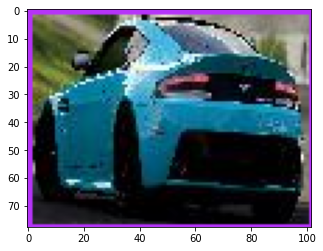

In [31]:
crop_out('/1466.jpg')

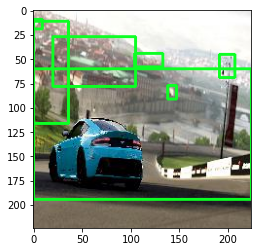

In [10]:
import cv2
import numpy as np

image = cv2.imread(image_dir + "/1466.jpg")
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
canny = cv2.Canny(blurred, 120, 255, 1)
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(canny, kernel, iterations=1)

# Find contours
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Iterate thorugh contours and filter for ROI
image_number = 0
for i,c in enumerate(cnts):
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    ROI = original[y:y+h, x:x+w]
    cv2.imwrite("ROI_{}.png".format(image_number), ROI)
    image_number += 1

#Show the image with matplotlib
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

areas of counter 0: 126
areas of counter 1: 30016
areas of counter 2: 384
areas of counter 3: 406
areas of counter 4: 4335
areas of counter 5: 3780
areas of counter 6: 90
largest area is 30016


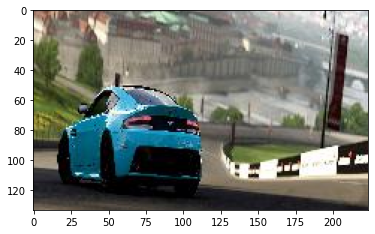

In [11]:
image = cv2.imread(image_dir + "/1466.jpg")
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
canny = cv2.Canny(blurred, 120, 255, 1)
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(canny, kernel, iterations=1)

# Find contours
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Iterate thorugh contours and find the largest rectangle
area = 0
for i,c in enumerate(cnts):
    _x,_y,_w,_h = cv2.boundingRect(c)
    _area = (_w)*(_h)
    print("areas of counter {}: {}".format(i, _area))
    if _area > area:
        area = _area
        x,y,w,h = _x,_y,_w,_h

print("largest area is {}".format(area))
cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
ROI = original[y:y+h, x:x+w]


#Show the image with matplotlib
image = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

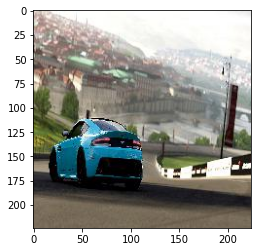

In [12]:
image = cv2.imread(image_dir + "/1466.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [13]:
# downloading the pretrained model
model = models.vgg16(pretrained=True)

model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("GPU is available!")
else:
    print("GPU is not available!")

GPU is available!


In [15]:
# freezing the feature extracting layer
for param in model.features.parameters():
    param.requires_grad = False

# modifying the existing last layer of classifier for our use case
model.classifier[6].out_features = len(classes)

# reviewing the changes
print(model.classifier)

if train_on_gpu:
    model = model.cuda()

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [0]:
from torch import optim, nn

# specify the loss
criterion = nn.CrossEntropyLoss()

# specify the optimizer
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [21]:
torch.cuda.device_count()

1

In [20]:
import time

epochs = 10

valid_loss_min = np.Inf

for epoch in range(epochs):
    
    epoch_start = time.time()
    train_loss = 0.
    valid_loss = 0.
    batch_num = 0
    batch_start = time.time()
    # training the model
    model.train()
    for images, labels in train_loader:
        # sending the tensors to cuda if gpu is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()

        # clearing the accumulated gradients
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculating the batch loss
        loss = criterion(output, labels)
        # back propagation
        loss.backward()
        # updating the weights
        optimizer.step()

        # updatind the training loss
        train_loss += loss.item()*images.size(0)

        batch_end = time.time()
        if (batch_num%10 == 0):
            print('Epcoh {}, batch {} completed. Time taken : {}'.format(epoch, batch_num, batch_end - batch_start))
        batch_start = time.time()
        batch_num +=1

    
    # evaluating the model
    model.eval()
    for images, labels in valid_loader:
        # sending the tensors to CUDA if GPU is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()

        # predicting the outcomes
        output = model(images)
        # calculating the loss
        loss = criterion(output, labels)

        # updating the validation loss
        valid_loss += loss.item()*images.size(0)

    # calculating the average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    epoch_end = time.time()

    # printing the loss for each epoch
    print("Epoch {}: , training loss: {:.6f}, validation loss: {:.6f},\
     time taken: {}".format(epoch+1, train_loss, valid_loss, 
                            epoch_end - epoch_start))
    
    if valid_loss < valid_loss_min:
        print("Validation loss decreased from {:.6f} --> {:.6f}. Saving the model...".
              format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), '/content/drive/My Drive/Resources/Dataset/janata-hackathon/model.pt')
        valid_loss_min = valid_loss


Epcoh 0, batch 0 completed. Time taken : 43.60590577125549
Epcoh 0, batch 10 completed. Time taken : 43.94247508049011
Epcoh 0, batch 20 completed. Time taken : 43.9361298084259
Epcoh 0, batch 30 completed. Time taken : 43.50526785850525
Epcoh 0, batch 40 completed. Time taken : 43.359591007232666


KeyboardInterrupt: ignored

In [0]:
model.load_state_dict(torch.load('/content/drive/My Drive/Resources/Dataset/janata-hackathon/model.pt'))

In [0]:
model.eval()
#test_set = next(iter(test_loader))
test_results = []
for images in test_loader:
    # if GPU is available, sending the data to it
    if train_on_gpu:
        images = images.cuda()
    # taking out the predictions
    output = model(images)
    # coverting model probabilities to predicted classes
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    test_results.extend(preds)

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))

#saving images to CPU to avoid errors
images = images.cpu()

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{}".format(classes[preds[idx]]))

In [0]:
df = pd.read_csv(test_csv_file)
df["emergency_or_not"] = test_results
df.to_csv("submission.csv", index=False)